In [1]:
%matplotlib inline
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm, trange
from utils import *
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Bayes By Backprop

Posterior Distribution (Reparameterized Gaussian)

In [2]:
class Reparameterized_Gaussian(object):
    def __init__(self, mu, rho):
        super().__init__()
        self.mu = mu
        self.rho = rho
        self.normal = torch.distributions.Normal(0,1)
    
    @property
    def sigma(self):
        return torch.log1p(torch.exp(self.rho))
    
    def sample(self):
        epsilon = self.normal.sample(self.rho.size()).to(DEVICE)
        return self.mu + self.sigma * epsilon
    
    def log_prob(self, weights):
        return (-math.log(math.sqrt(2 * math.pi))
                - torch.log(self.sigma)
                - ((weights - self.mu) ** 2) / (2 * self.sigma ** 2)).sum()

Prior Distribution (select either Gaussian or Scaled  Mixture)

In [3]:
class ScaleMixtureGaussian(object):
    def __init__(self, pi, sigma1, sigma2):
        super().__init__()
        self.pi = pi
        self.sigma1 = sigma1
        self.sigma2 = sigma2
        self.gaussian1 = torch.distributions.Normal(0,sigma1)
        self.gaussian2 = torch.distributions.Normal(0,sigma2)
    
    def log_prob(self, weights):
        prob1 = torch.exp(self.gaussian1.log_prob(weights))
        prob2 = torch.exp(self.gaussian2.log_prob(weights))
        return (torch.log(self.pi * prob1 + (1-self.pi) * prob2)).sum()
    
class Gaussian:
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
        self.gaussian = torch.distributions.Normal(mu,sigma)
    def log_prob(self, weights):
        prob = self.gaussian.log_prob(weights)
        return prob.sum()

Bayesian Layer

In [4]:
class BayesianLayer(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim

        self.weight_mu = nn.Parameter(torch.Tensor(output_dim, input_dim).uniform_(-0.01, 0.01))
        self.weight_rho = nn.Parameter(torch.Tensor(output_dim, input_dim).uniform_(-3,-3))
        self.weight = Reparameterized_Gaussian(self.weight_mu, self.weight_rho)
        self.bias_mu = nn.Parameter(torch.Tensor(output_dim).uniform_(-0.01, 0.01))
        self.bias_rho = nn.Parameter(torch.Tensor(output_dim).uniform_(-4,-3))
        self.bias = Reparameterized_Gaussian(self.bias_mu, self.bias_rho)
        SIGMA_1 = torch.FloatTensor([math.exp(-0)])
        SIGMA_2 = torch.FloatTensor([math.exp(-6)])
        PI = 0.5
        self.weight_prior = ScaleMixtureGaussian(PI, SIGMA_1, SIGMA_2)
        self.bias_prior = ScaleMixtureGaussian(PI, SIGMA_1, SIGMA_2)
        self.log_prior = 0
        self.log_variational_posterior = 0

    def forward(self, input, sample=False, calculate_log_probs=False):
        if self.training or sample:
            weight = self.weight.sample()
            bias = self.bias.sample()
        else:
            weight = self.weight.mu
            bias = self.bias.mu
        if self.training or calculate_log_probs:
            self.log_prior = self.weight_prior.log_prob(weight) + self.bias_prior.log_prob(bias)
            self.log_variational_posterior = self.weight.log_prob(weight) + self.bias.log_prob(bias)
        else:
            self.log_prior, self.log_variational_posterior = 0, 0

        return F.linear(input, weight, bias)

Bayesian Network

In [5]:
class BayesianNetwork(nn.Module):
    def __init__(self, input_dim, num_units, output_dim, alpha, lambda_,soften):
        super().__init__()
        self.alpha = alpha
        self.lambda_ = lambda_
        self.soften=soften
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.l1 = BayesianLayer(input_dim,num_units)
        self.l2 = BayesianLayer(num_units, num_units)
        self.l3 = BayesianLayer(num_units, 2*output_dim)
    
    def forward(self, X, sample=False):
        X = X.view(-1, self.input_dim)
        X = F.relu(self.l1(X, sample))
        X = F.relu(self.l2(X, sample))
        X = self.l3(X, sample)
        return X
    
    def log_prior(self):
        return self.l1.log_prior \
               + self.l2.log_prior \
               + self.l3.log_prior
    
    def log_variational_posterior(self):
        return self.l1.log_variational_posterior \
               + self.l2.log_variational_posterior \
               + self.l3.log_variational_posterior

    def qd_loss(self,pred_U, pred_L, target): 
        N_ = torch.Tensor([target.shape[0]])
        alpha_ = torch.Tensor([self.alpha])
        lambda_ = torch.Tensor([self.lambda_]) 
        soften =torch.Tensor([self.soften]) 
        gamma_U = torch.sigmoid((pred_U - target)*soften)
        gamma_L = torch.sigmoid((target - pred_L)*soften)
        gamma_ = torch.mul(gamma_U, gamma_L)
        PICP_soft = gamma_.mean()
        qd_rhs_soft = lambda_*torch.sqrt(N_)*(torch.max(torch.Tensor([0.]), (1.- alpha_)-PICP_soft))**2
        qd_lhs_soft = ((torch.abs(pred_U - pred_L)*gamma_).sum())/(gamma_.sum()+torch.Tensor([0.001]))
        qd_loss_soft = qd_lhs_soft + qd_rhs_soft
        return qd_loss_soft

    def sample_elbo(self, X, y, num_samples):
        log_prior = 0
        log_variational_posterior = 0
        qd_loss=0
        for i in range(num_samples):
            output = self(X, sample=True)
            log_prior += self.log_prior()
            log_variational_posterior+= self.log_variational_posterior()   
            pred_U = output[:,:1]
            pred_L = output[:,1:]
            qd_loss += self.qd_loss(pred_U, pred_L, y)
        loss = ((log_variational_posterior - log_prior)/(num_samples*X.shape[0])) +qd_loss
        return loss, log_prior, log_variational_posterior, qd_loss


A Wrapper for a Bayesian Network Model

In [6]:
class BayesianNetwork_Model:
    def __init__(self, network, learn_rate,y_scale):
        self.y_scale= y_scale
        self.learn_rate = learn_rate
        self.network = network
        self.network.to(DEVICE)
        self.optimizer = torch.optim.Adam(self.network.parameters(),lr=self.learn_rate)
        
    def fit (self, X, y, num_samples):
        self.network.train()
        X, y = X.to(DEVICE), y.to(DEVICE)
        self.optimizer.zero_grad()
        loss, log_prior, log_variational_posterior, qd_loss = self.network.sample_elbo(X, y,num_samples)
        loss.backward()
        self.optimizer.step()
        return loss, log_prior, log_variational_posterior, qd_loss
    
    def predict(self, X, num_samples):
        self.network.eval()
        X = X.to(DEVICE)
        pred_Us, pred_Ls, pred_means = [], [],[]        
        for i in range(num_samples):
            output = self.network(X)
            pred_U = output[:, :1, None]
            pred_L = output[:, 1:, None]
            pred_mean = output.mean(dim=1,keepdim=True )[:,:, None]
            pred_Us.append(pred_U)
            pred_Ls.append(pred_L)
            pred_means.append(pred_mean)
        pred_Us = torch.cat(pred_Us, 2)
        pred_Ls =  torch.cat(pred_Ls, 2)
        pred_means = torch.cat(pred_means, 2)
        pred_U = pred_Us.mean(dim=2)
        pred_L = pred_Ls.mean(dim=2)
        pred_mean = pred_means.mean(dim=2)
        return pred_U, pred_L, pred_mean
    
    def evaluate(self, test_loader, num_samples, gamma):
        if gamma == 0.95:
            n_std_devs = 1.96
        elif gamma == 0.90:
            n_std_devs = 1.645
        elif gamma == 0.99:
            n_std_devs = 2.575
        else:
            raise Exception('ERROR unusual gamma')

        pred_U, pred_L,pred_mean,features, target = [],[],[],[],[]
        for batch_idx, (X_test, y_test) in enumerate(test_loader):
            batch_pred_U, batch_pred_L, batch_pred_mean = self.predict(X_test, num_samples)
            pred_U.append(batch_pred_U)
            pred_L.append(batch_pred_L)
            pred_mean.append(batch_pred_mean)
            features.append(X_test)
            target.append(y_test)
        pred_U = torch.cat(pred_U, dim=0)
        pred_L = torch.cat(pred_L, dim=0)
        pred_mean = torch.cat(pred_mean, dim=0)
        features = torch.cat(features, dim=0)
        target = torch.cat(target, dim=0) 
        rmse=((pred_mean - target)**2).mean()**0.5
        k_U = torch.max(torch.tensor(0.),torch.sign(pred_U - target))
        k_L = torch.max(torch.tensor(0.),torch.sign(target - pred_L))
        k= torch.mul(k_U, k_L)
        PICP= k.mean()
        MPIW =(pred_U-pred_L).mean()
        rmse = float(rmse.cpu().data)*self.y_scale
        PICP = float(PICP.cpu().data)
        MPIW = float(MPIW.cpu().data)  
        return rmse, PICP, MPIW, pred_mean, pred_U, pred_L, features, target             

## Hyper-parameters

In [7]:
BATCH_SIZE =128 
TEST_BATCH_SIZE = 128
TRAIN_EPOCHS = 100
NUM_SAMPLES_TRAIN = 20
NUM_SAMPLES_TEST= 1000
OUTPUT_DIM = 1
NUM_UNITS = 100
GAMMA = 0.95
ALPHA = 0.05
LAMBDA_=15
SOFTEN = 160
learn_rate=1e-2
log_every=10
model_name='Bayes_qd'

## Boston Housing

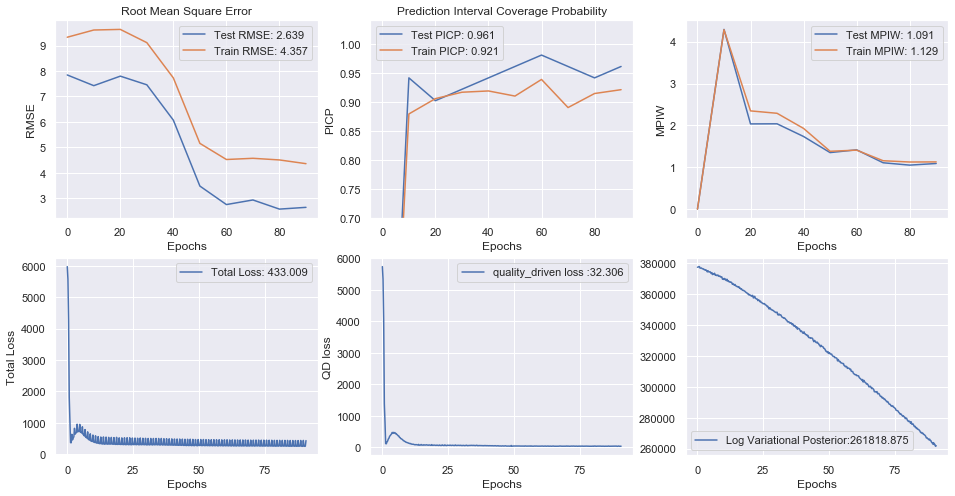

100%|██████████| 100/100 [01:26<00:00,  1.30it/s]


 RMSE = 2.763, PICP = 0.941, MPIW = 0.978


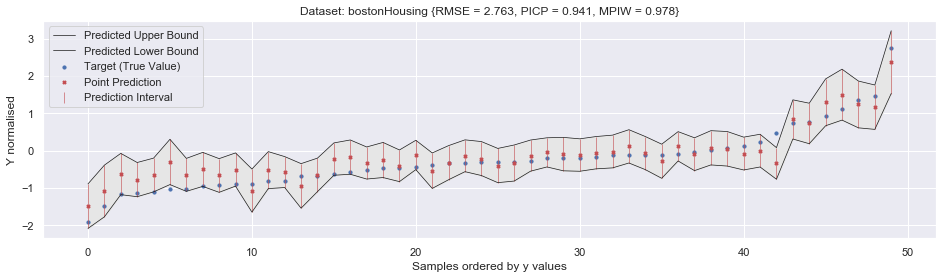

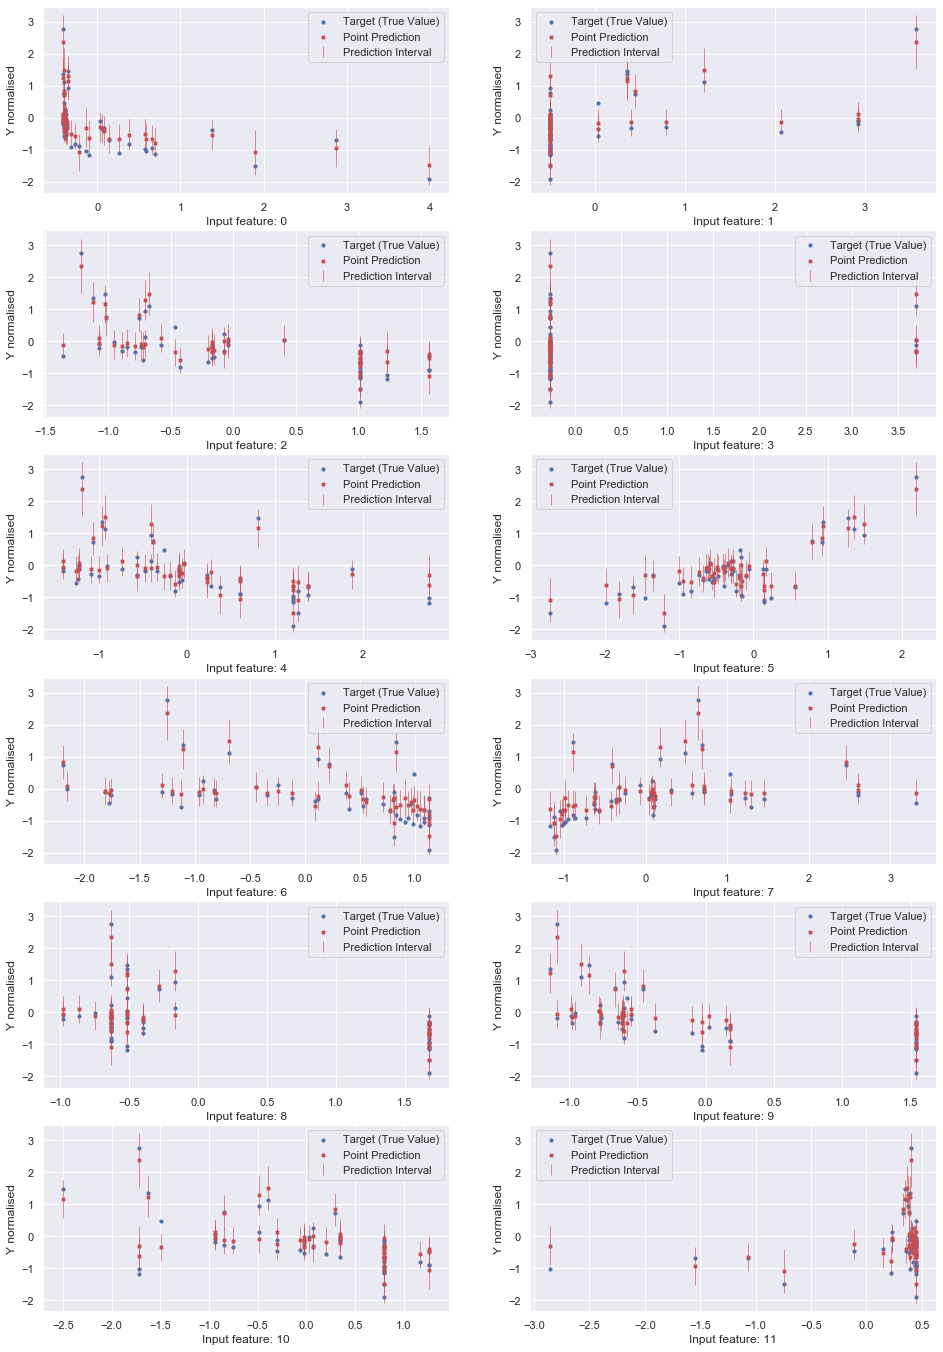

In [8]:
DATA_DIR="bostonHousing"

train_loader, test_loader, y_scale= load_normalize_data(data_dir=DATA_DIR,
                                                        train_batch_size=BATCH_SIZE,
                                                        test_batch_size=TEST_BATCH_SIZE)

TRAIN_SIZE = len(train_loader.dataset)
TEST_SIZE = len(test_loader.dataset)
NUM_BATCHES = len(train_loader)
NUM_TEST_BATCHES = len(test_loader)

INPUT_DIM=train_loader.dataset.features.shape[-1]


bostonHousing_model= BayesianNetwork_Model(network=BayesianNetwork(input_dim=INPUT_DIM, 
                                             output_dim=OUTPUT_DIM, 
                                             num_units=NUM_UNITS,alpha=ALPHA,lambda_ =LAMBDA_,soften = SOFTEN),
                                   learn_rate=learn_rate, 
                                   y_scale=y_scale)





train_Bayes(bostonHousing_model,train_loader, test_loader,TRAIN_EPOCHS,NUM_SAMPLES_TRAIN,GAMMA, log_every, DATA_DIR,model_name,qd=True)
evaluate_model(bostonHousing_model, test_loader,NUM_SAMPLES_TEST,GAMMA, DATA_DIR,model_name)



## Concrete

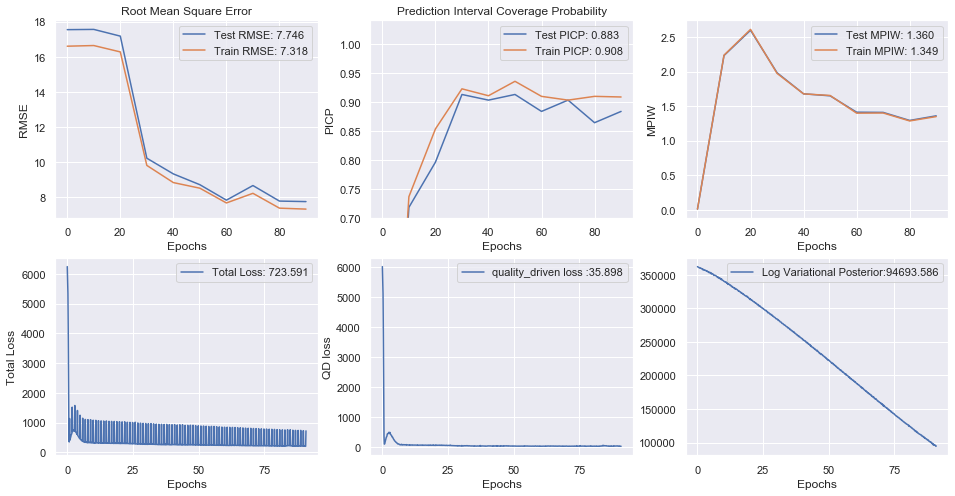

100%|██████████| 100/100 [02:42<00:00,  1.50s/it]


 RMSE = 6.928, PICP = 0.816, MPIW = 1.002


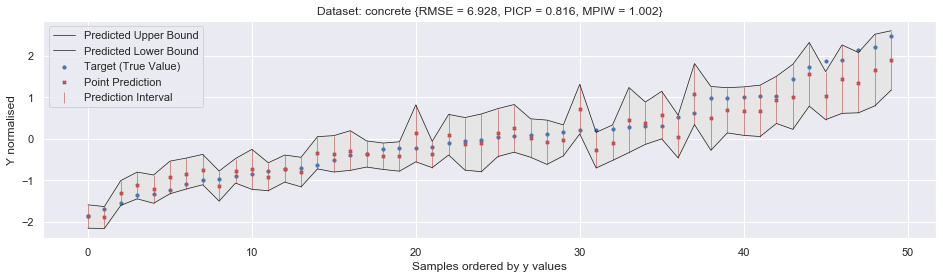

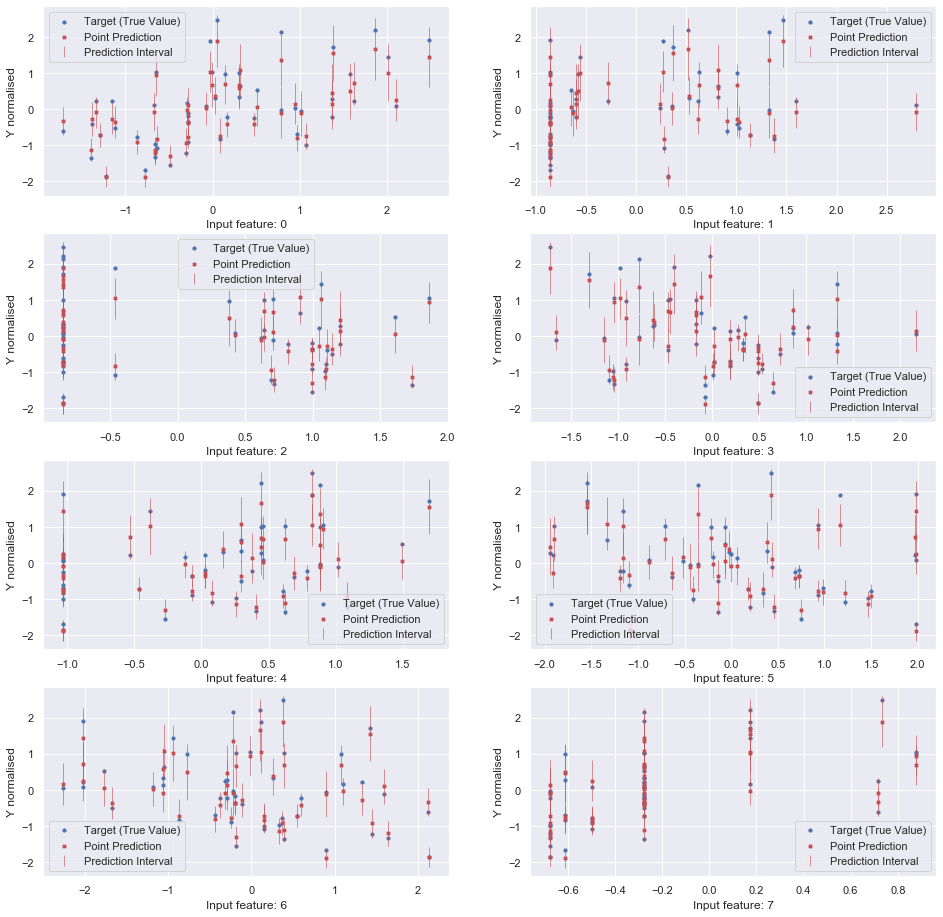

In [9]:
DATA_DIR="concrete"

train_loader, test_loader, y_scale= load_normalize_data(data_dir=DATA_DIR,
                                                        train_batch_size=BATCH_SIZE,
                                                        test_batch_size=TEST_BATCH_SIZE)

TRAIN_SIZE = len(train_loader.dataset)
TEST_SIZE = len(test_loader.dataset)
NUM_BATCHES = len(train_loader)
NUM_TEST_BATCHES = len(test_loader)

INPUT_DIM=train_loader.dataset.features.shape[-1]


concrete_model= BayesianNetwork_Model(network=BayesianNetwork(input_dim=INPUT_DIM, 
                                             output_dim=OUTPUT_DIM, 
                                             num_units=NUM_UNITS,alpha=ALPHA,lambda_ =LAMBDA_,soften = SOFTEN),
                                   learn_rate=learn_rate, 
                                   y_scale=y_scale)

train_Bayes(concrete_model,train_loader, test_loader,TRAIN_EPOCHS,NUM_SAMPLES_TRAIN,GAMMA, log_every, DATA_DIR,model_name,qd=True)
evaluate_model(concrete_model, test_loader,NUM_SAMPLES_TEST,GAMMA, DATA_DIR,model_name)



## energy_heating_load

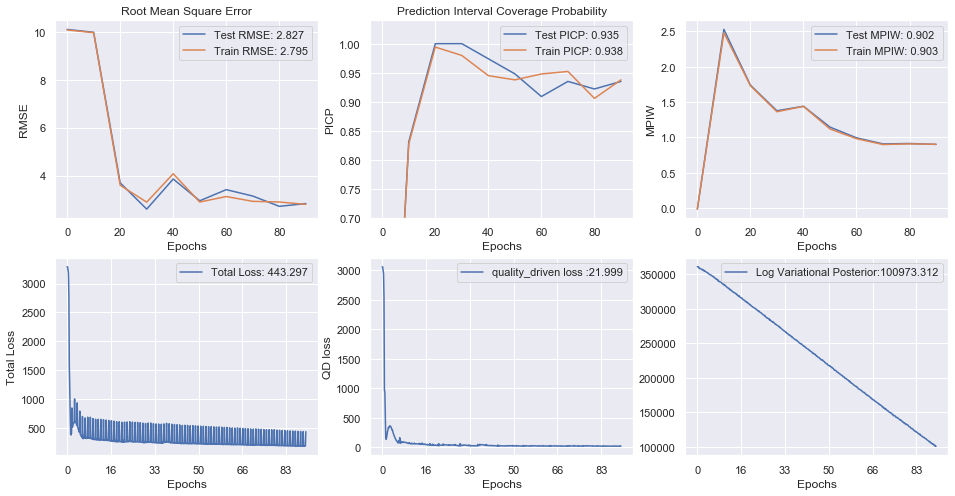

100%|██████████| 100/100 [02:05<00:00,  1.17s/it]


 RMSE = 3.106, PICP = 0.896, MPIW = 0.905


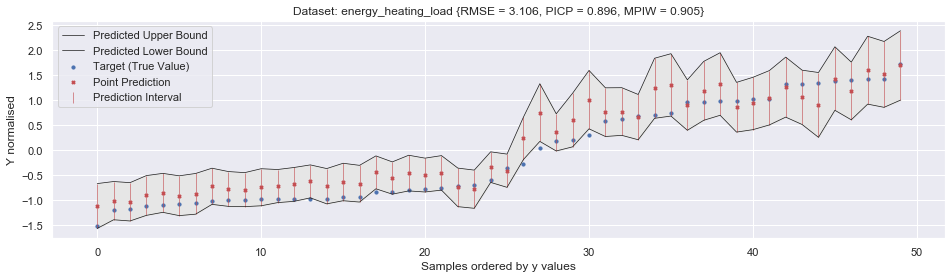

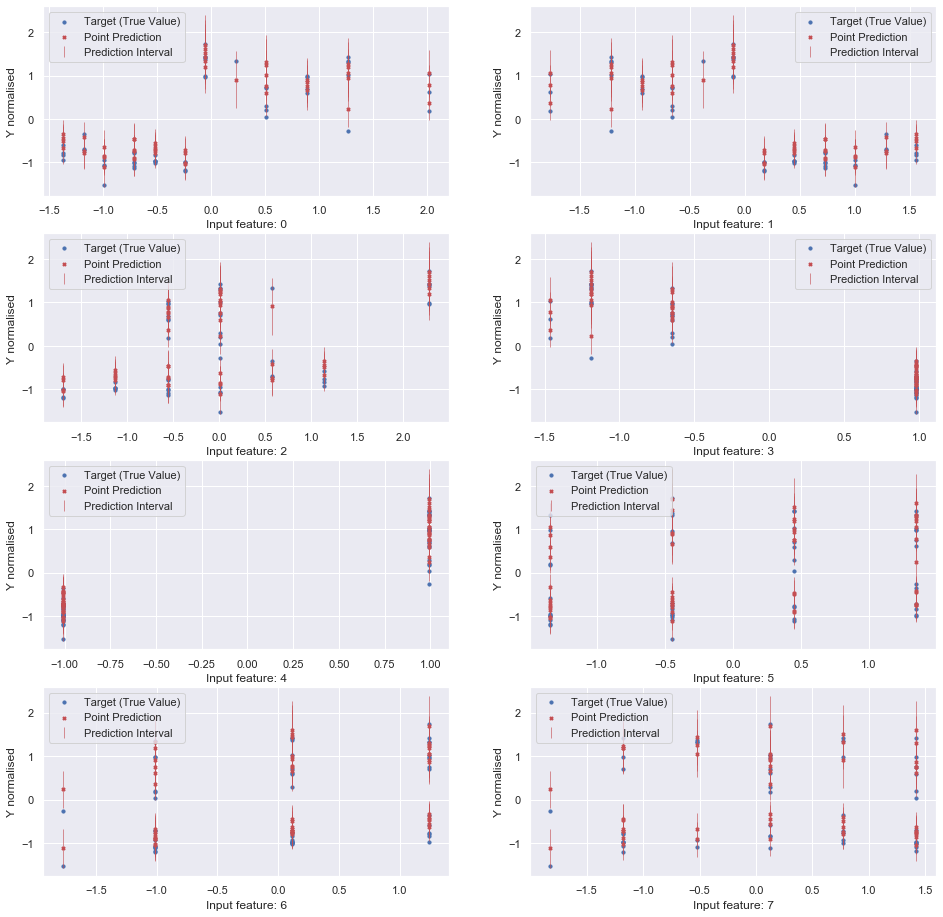

In [11]:
BATCH_SIZE =128 
TEST_BATCH_SIZE = 128
TRAIN_EPOCHS = 100
NUM_SAMPLES_TRAIN = 20
NUM_SAMPLES_TEST= 1000
OUTPUT_DIM = 1
NUM_UNITS = 100
GAMMA = 0.95
ALPHA = 0.05
LAMBDA_=15
SOFTEN = 160
learn_rate=1e-2
log_every=10
model_name='Bayes_qd'


DATA_DIR="energy_heating_load"

train_loader, test_loader, y_scale= load_normalize_data(data_dir=DATA_DIR,
                                                        train_batch_size=BATCH_SIZE,
                                                        test_batch_size=TEST_BATCH_SIZE)

TRAIN_SIZE = len(train_loader.dataset)
TEST_SIZE = len(test_loader.dataset)
NUM_BATCHES = len(train_loader)
NUM_TEST_BATCHES = len(test_loader)

INPUT_DIM=train_loader.dataset.features.shape[-1]


energy_model= BayesianNetwork_Model(network=BayesianNetwork(input_dim=INPUT_DIM, 
                                             output_dim=OUTPUT_DIM, 
                                             num_units=NUM_UNITS,alpha=ALPHA,lambda_ =LAMBDA_,soften = SOFTEN),
                                   learn_rate=learn_rate, 
                                   y_scale=y_scale)

train_Bayes(energy_model,train_loader, test_loader,TRAIN_EPOCHS,NUM_SAMPLES_TRAIN,GAMMA, log_every, DATA_DIR,model_name,qd=True)
evaluate_model(energy_model, test_loader,NUM_SAMPLES_TEST,GAMMA, DATA_DIR,model_name)


## kin8nm

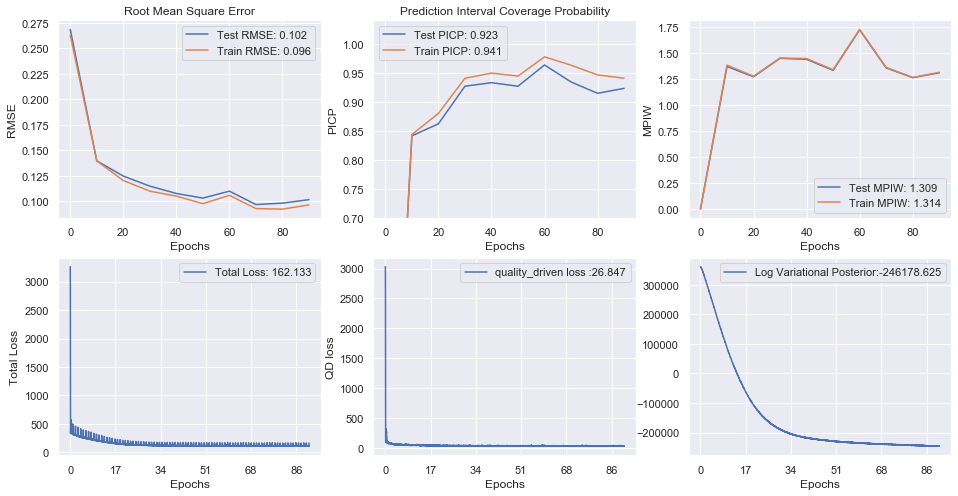

100%|██████████| 100/100 [19:08<00:00, 11.46s/it]


 RMSE = 0.094, PICP = 0.910, MPIW = 1.204


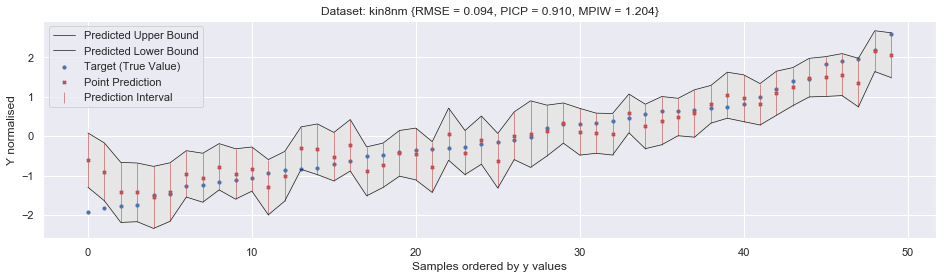

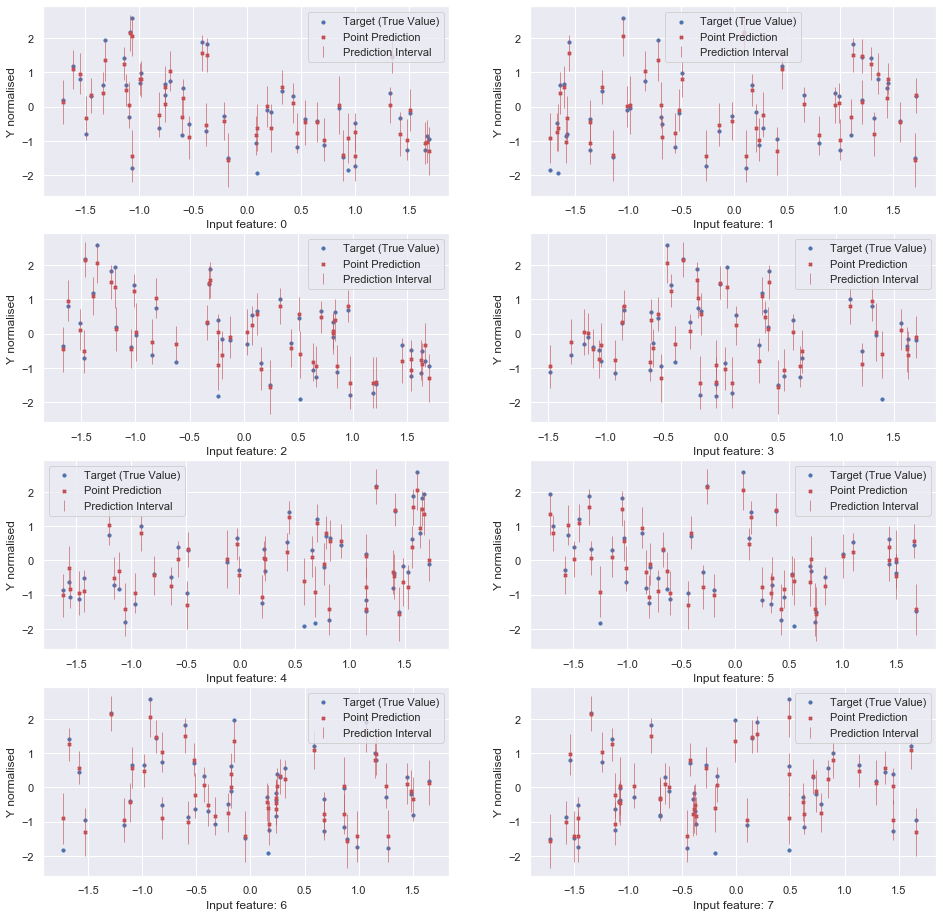

In [12]:
DATA_DIR="kin8nm"

train_loader, test_loader, y_scale= load_normalize_data(data_dir=DATA_DIR,
                                                        train_batch_size=BATCH_SIZE,
                                                        test_batch_size=TEST_BATCH_SIZE)

TRAIN_SIZE = len(train_loader.dataset)
TEST_SIZE = len(test_loader.dataset)
NUM_BATCHES = len(train_loader)
NUM_TEST_BATCHES = len(test_loader)

INPUT_DIM=train_loader.dataset.features.shape[-1]


kin8nm_model= BayesianNetwork_Model(network=BayesianNetwork(input_dim=INPUT_DIM, 
                                             output_dim=OUTPUT_DIM, 
                                             num_units=NUM_UNITS,alpha=ALPHA,lambda_ =LAMBDA_,soften = SOFTEN),
                                   learn_rate=learn_rate, 
                                   y_scale=y_scale)

train_Bayes(kin8nm_model,train_loader, test_loader,TRAIN_EPOCHS,NUM_SAMPLES_TRAIN,GAMMA, log_every, DATA_DIR,model_name,qd=True)
evaluate_model(kin8nm_model, test_loader,NUM_SAMPLES_TEST,GAMMA, DATA_DIR,model_name)



## Naval

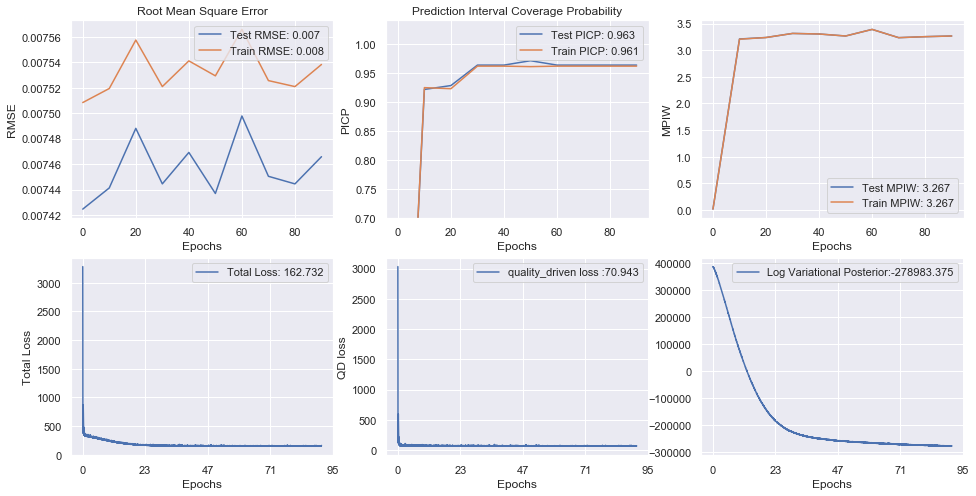

100%|██████████| 100/100 [31:19<00:00, 18.95s/it]


 RMSE = 0.007, PICP = 0.963, MPIW = 3.247


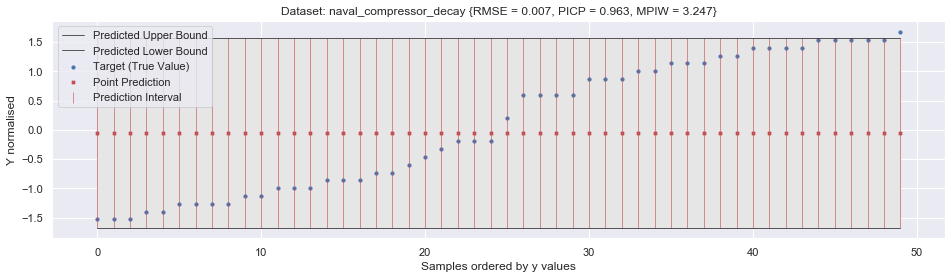

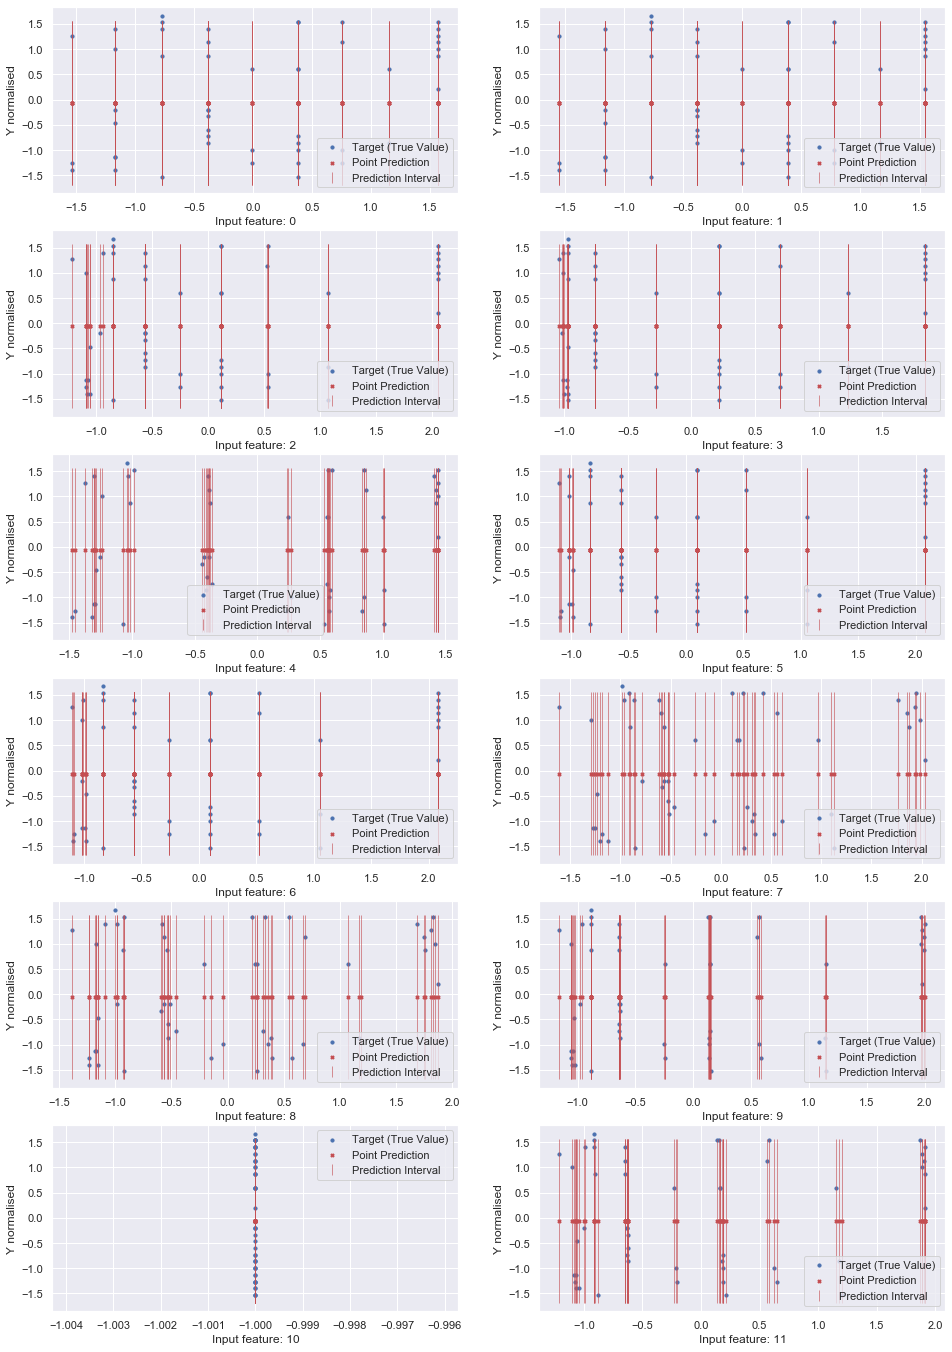

In [8]:
DATA_DIR="naval_compressor_decay"

train_loader, test_loader, y_scale= load_normalize_data(data_dir=DATA_DIR,
                                                        train_batch_size=BATCH_SIZE,
                                                        test_batch_size=TEST_BATCH_SIZE)

TRAIN_SIZE = len(train_loader.dataset)
TEST_SIZE = len(test_loader.dataset)
NUM_BATCHES = len(train_loader)
NUM_TEST_BATCHES = len(test_loader)

INPUT_DIM=train_loader.dataset.features.shape[-1]


naval_model= BayesianNetwork_Model(network=BayesianNetwork(input_dim=INPUT_DIM, 
                                             output_dim=OUTPUT_DIM, 
                                             num_units=NUM_UNITS,alpha=ALPHA,lambda_ =LAMBDA_,soften = SOFTEN),
                                   learn_rate=learn_rate, 
                                   y_scale=y_scale)

train_Bayes(naval_model,train_loader, test_loader,TRAIN_EPOCHS,NUM_SAMPLES_TRAIN,GAMMA, log_every, DATA_DIR,model_name,qd=True)
evaluate_model(naval_model, test_loader,NUM_SAMPLES_TEST,GAMMA, DATA_DIR,model_name)


## power

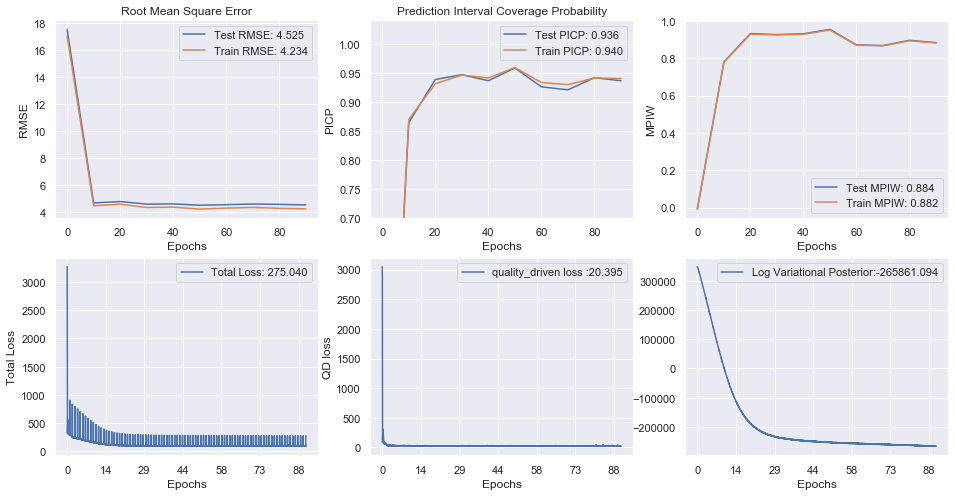

100%|██████████| 100/100 [21:51<00:00, 12.82s/it]


 RMSE = 4.517, PICP = 0.939, MPIW = 0.874


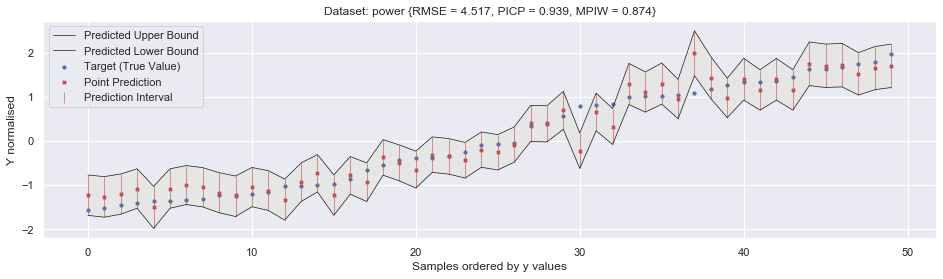

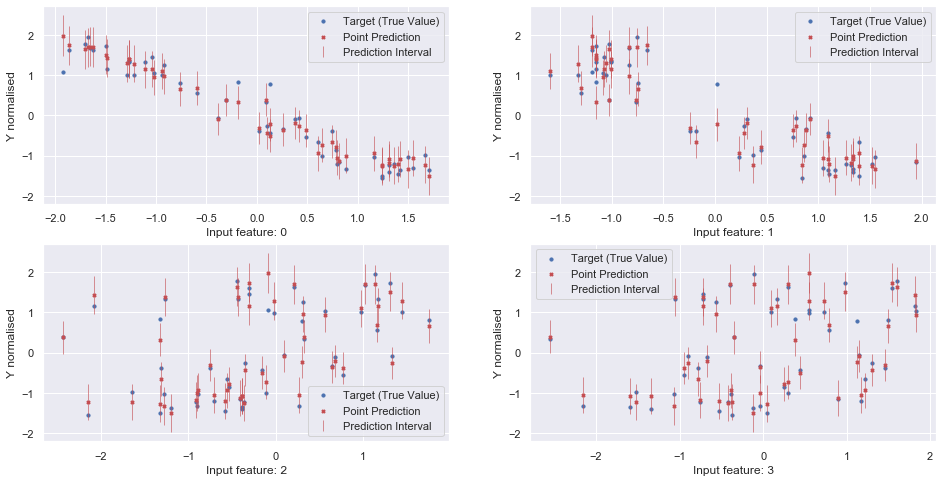

In [13]:
DATA_DIR="power"

train_loader, test_loader, y_scale= load_normalize_data(data_dir=DATA_DIR,
                                                        train_batch_size=BATCH_SIZE,
                                                        test_batch_size=TEST_BATCH_SIZE)

TRAIN_SIZE = len(train_loader.dataset)
TEST_SIZE = len(test_loader.dataset)
NUM_BATCHES = len(train_loader)
NUM_TEST_BATCHES = len(test_loader)

INPUT_DIM=train_loader.dataset.features.shape[-1]


power_model= BayesianNetwork_Model(network=BayesianNetwork(input_dim=INPUT_DIM, 
                                             output_dim=OUTPUT_DIM, 
                                             num_units=NUM_UNITS,alpha=ALPHA,lambda_ =LAMBDA_,soften = SOFTEN),
                                   learn_rate=learn_rate, 
                                   y_scale=y_scale)

train_Bayes(power_model,train_loader, test_loader,TRAIN_EPOCHS,NUM_SAMPLES_TRAIN,GAMMA, log_every, DATA_DIR,model_name,qd=True)
evaluate_model(power_model, test_loader,NUM_SAMPLES_TEST,GAMMA, DATA_DIR,model_name)



## protein

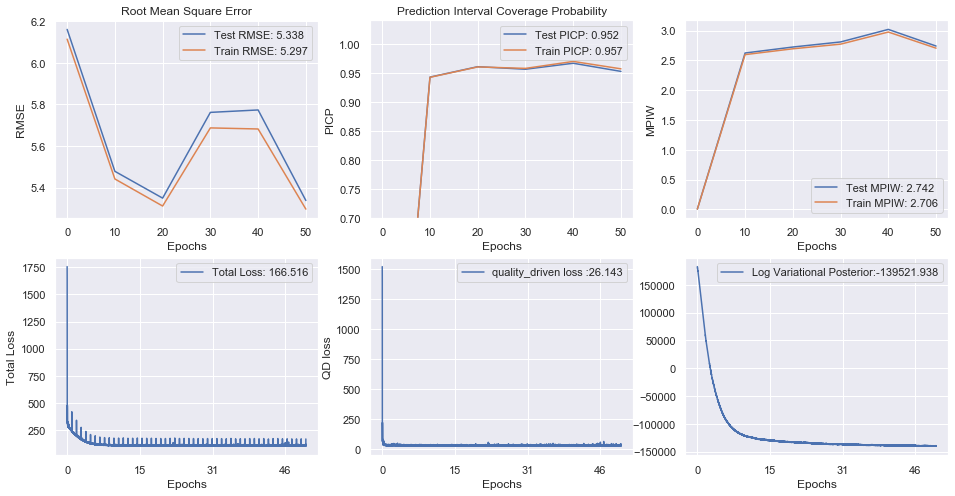

100%|██████████| 58/58 [30:45<00:00, 31.41s/it]


 RMSE = 5.550, PICP = 0.960, MPIW = 2.909


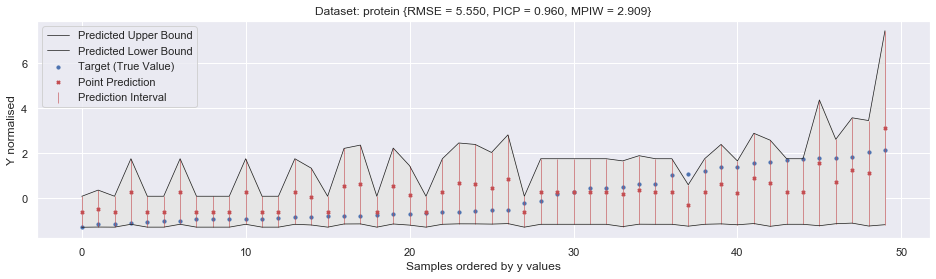

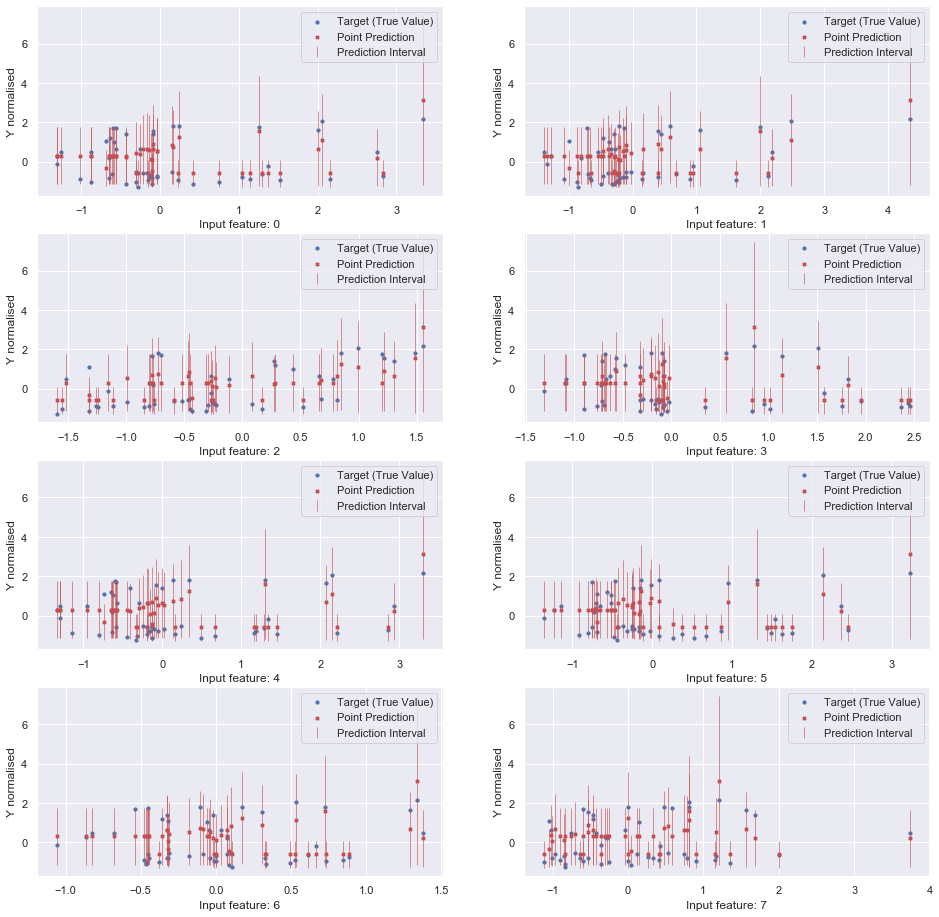

In [16]:
BATCH_SIZE =128 
TEST_BATCH_SIZE = 128
TRAIN_EPOCHS = 58
NUM_SAMPLES_TRAIN = 10
NUM_SAMPLES_TEST= 1000
OUTPUT_DIM = 1
NUM_UNITS = 100
GAMMA = 0.95
ALPHA = 0.05
LAMBDA_=15
SOFTEN = 160
learn_rate=1e-2
log_every=10
model_name='Bayes_qd'


DATA_DIR="protein"

train_loader, test_loader, y_scale= load_normalize_data(data_dir=DATA_DIR,
                                                        train_batch_size=BATCH_SIZE,
                                                        test_batch_size=TEST_BATCH_SIZE)

TRAIN_SIZE = len(train_loader.dataset)
TEST_SIZE = len(test_loader.dataset)
NUM_BATCHES = len(train_loader)
NUM_TEST_BATCHES = len(test_loader)

INPUT_DIM=train_loader.dataset.features.shape[-1]

protein_model= BayesianNetwork_Model(network=BayesianNetwork(input_dim=INPUT_DIM, 
                                             output_dim=OUTPUT_DIM, 
                                             num_units=NUM_UNITS,alpha=ALPHA,lambda_ =LAMBDA_,soften = SOFTEN),
                                   learn_rate=learn_rate, 
                                   y_scale=y_scale)

train_Bayes(protein_model,train_loader, test_loader,TRAIN_EPOCHS,NUM_SAMPLES_TRAIN,GAMMA, log_every, DATA_DIR,model_name,qd=True)
evaluate_model(protein_model, test_loader,NUM_SAMPLES_TEST,GAMMA, DATA_DIR,model_name)


## wine

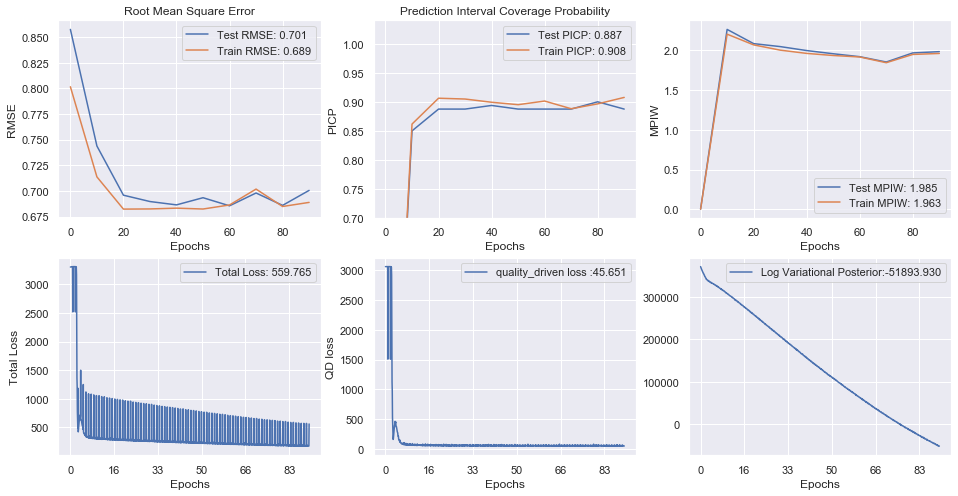

100%|██████████| 100/100 [03:58<00:00,  2.30s/it]


 RMSE = 0.691, PICP = 0.900, MPIW = 1.916


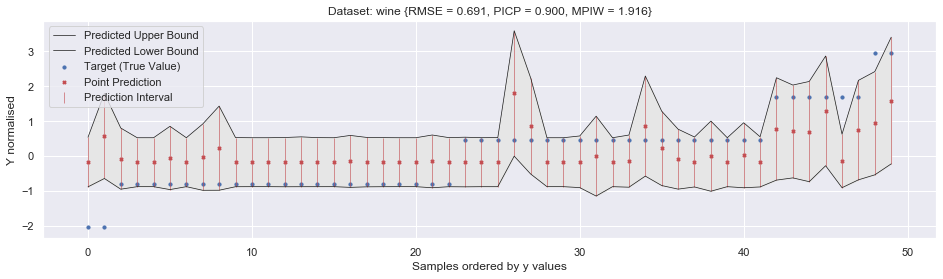

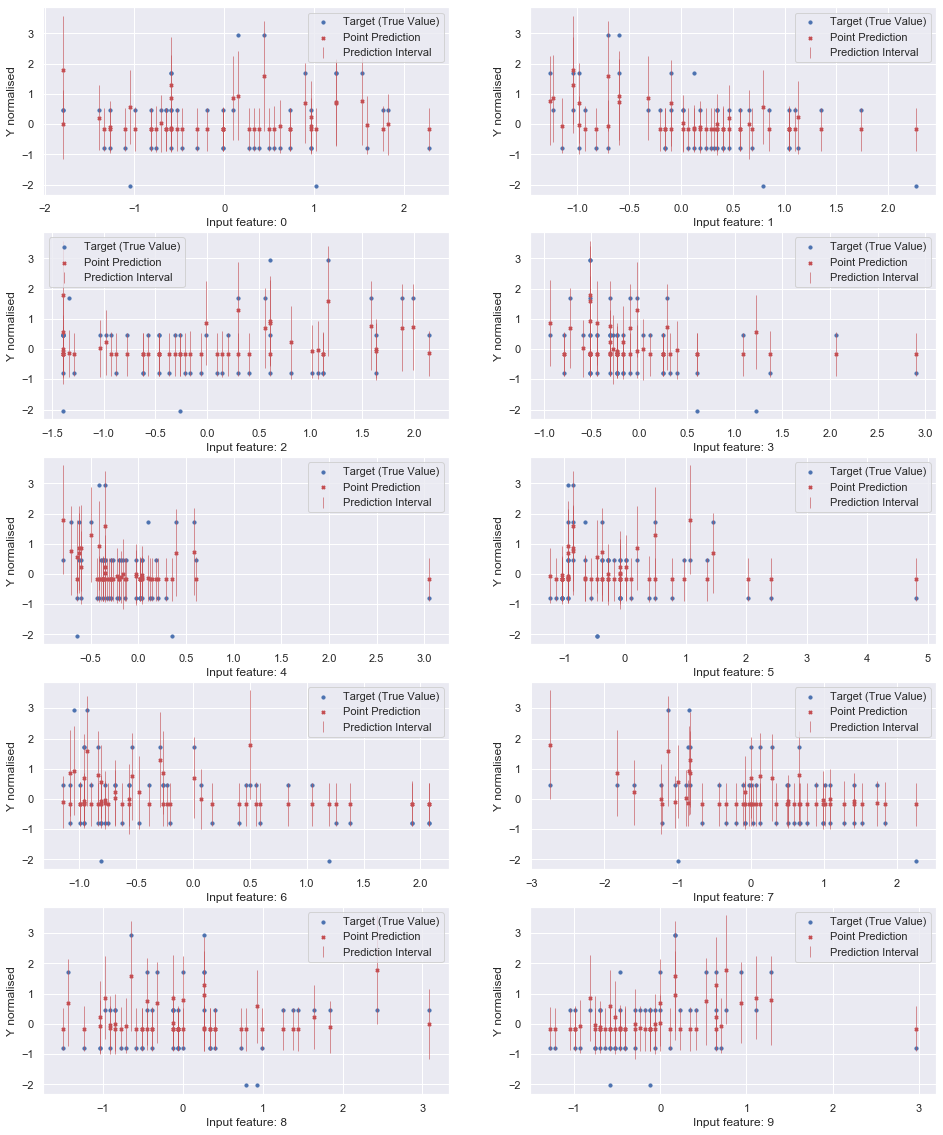

In [15]:
DATA_DIR="wine"

train_loader, test_loader, y_scale= load_normalize_data(data_dir=DATA_DIR,
                                                        train_batch_size=BATCH_SIZE,
                                                        test_batch_size=TEST_BATCH_SIZE)

TRAIN_SIZE = len(train_loader.dataset)
TEST_SIZE = len(test_loader.dataset)
NUM_BATCHES = len(train_loader)
NUM_TEST_BATCHES = len(test_loader)

INPUT_DIM=train_loader.dataset.features.shape[-1]

wine_model= BayesianNetwork_Model(network=BayesianNetwork(input_dim=INPUT_DIM, 
                                             output_dim=OUTPUT_DIM, 
                                             num_units=NUM_UNITS,alpha=ALPHA,lambda_ =LAMBDA_,soften = SOFTEN),
                                   learn_rate=learn_rate, 
                                   y_scale=y_scale)

train_Bayes(wine_model,train_loader, test_loader,TRAIN_EPOCHS,NUM_SAMPLES_TRAIN,GAMMA, log_every, DATA_DIR,model_name,qd=True)
evaluate_model(wine_model, test_loader,NUM_SAMPLES_TEST,GAMMA, DATA_DIR,model_name)



## yacht

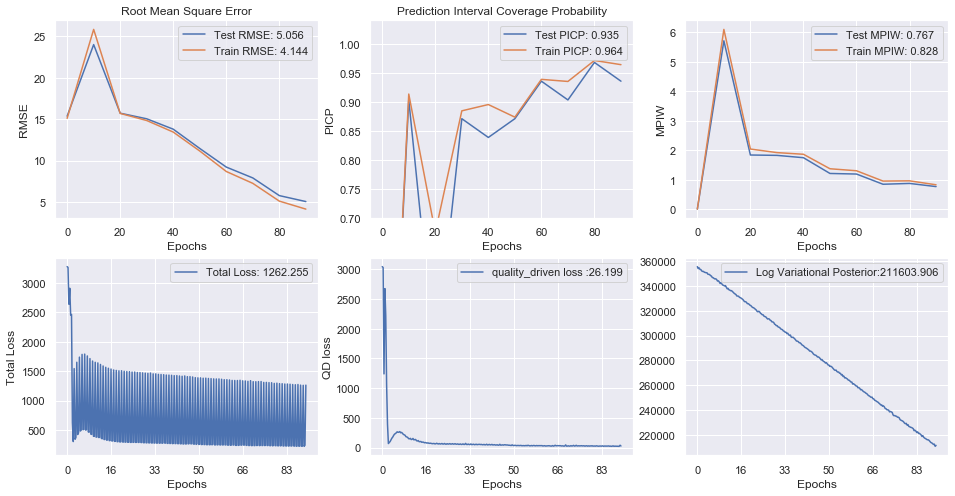

100%|██████████| 100/100 [01:53<00:00,  1.72it/s]


 RMSE = 3.557, PICP = 0.968, MPIW = 0.722


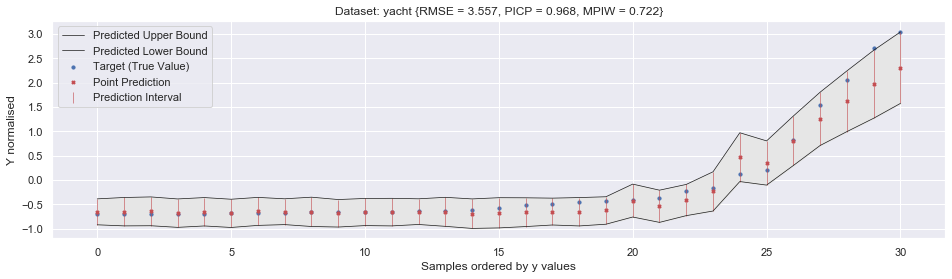

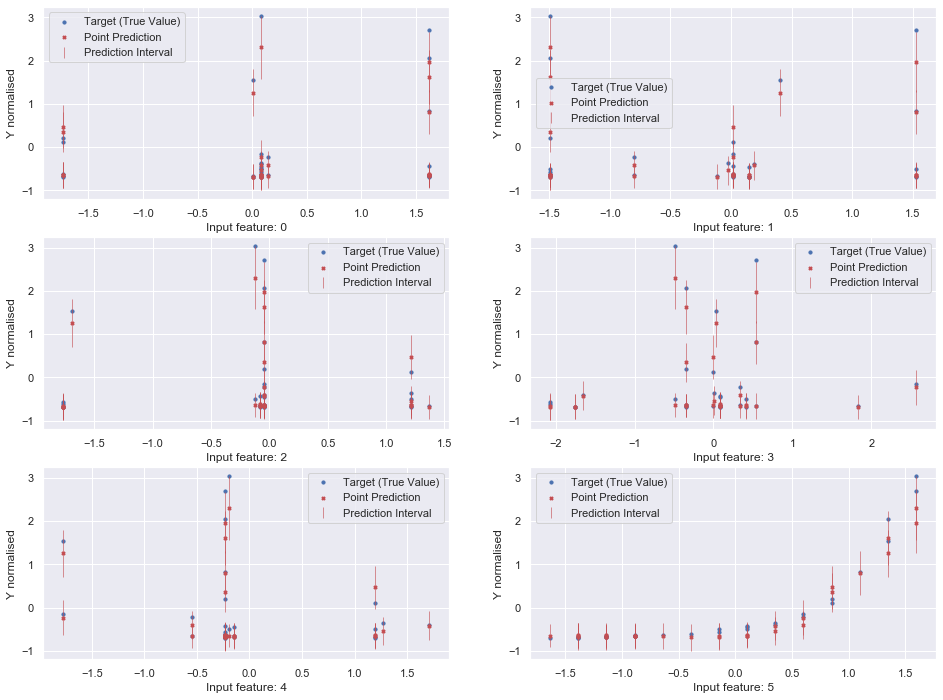

In [14]:
DATA_DIR="yacht"

train_loader, test_loader, y_scale= load_normalize_data(data_dir=DATA_DIR,
                                                        train_batch_size=BATCH_SIZE,
                                                        test_batch_size=TEST_BATCH_SIZE)

TRAIN_SIZE = len(train_loader.dataset)
TEST_SIZE = len(test_loader.dataset)
NUM_BATCHES = len(train_loader)
NUM_TEST_BATCHES = len(test_loader)

INPUT_DIM=train_loader.dataset.features.shape[-1]

yacht_model= BayesianNetwork_Model(network=BayesianNetwork(input_dim=INPUT_DIM, 
                                             output_dim=OUTPUT_DIM, 
                                             num_units=NUM_UNITS,alpha=ALPHA,lambda_ =LAMBDA_,soften = SOFTEN),
                                   learn_rate=learn_rate, 
                                   y_scale=y_scale)

train_Bayes(yacht_model,train_loader, test_loader,TRAIN_EPOCHS,NUM_SAMPLES_TRAIN,GAMMA, log_every, DATA_DIR,model_name,qd=True)
evaluate_model(yacht_model, test_loader,NUM_SAMPLES_TEST,GAMMA, DATA_DIR,model_name)

